# Prophet

Prophet is open source software that was developed at Facebook (now known as Meta) by Sean J. Taylor and Ben Lethan.

Prophet's model consists of using a decomposable time series model that takes into account three important factors: trend, seasonality and holidays. These components are combined in the equation
$$ y(t) = g(t) + s(t) + h(t) + \varepsilon_t.$$


The value predicted $y$ by the model at time $t$ is given by the function y(t) and
* $g(t)$ is the tend component.
* $s(t)$ is the seasonal component.
* $h(t)$ represents the effects of holidays.
* $\varepsilon_t$ is the error term that represents the changen that are not accommodated by the model.

### Index
* [First Prophet Model](#first_model)
* [Prophet with Holidays](#hday)
* [Using Cross-Validation for the best parameters](#crossval)
* [Prediction into the furute](#future)
* [Other plots](#graphs)

**Packages**

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import itertools

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns

import os
from pathlib import Path
project_path = Path(os.getcwd()).parent
import pickle
import joblib  

np.random.seed(2530)

In [2]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# Change the font size 
matplotlib.rc("font", size=small_size)  
matplotlib.rc("axes", titlesize=small_size)  
matplotlib.rc("axes", labelsize=medium_size)  
matplotlib.rc("xtick", labelsize=small_size)  
matplotlib.rc("ytick", labelsize=small_size)  
matplotlib.rc("legend", fontsize=small_size)  
matplotlib.rc("axes", titlesize=large_size) 

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape
from sklearn.metrics import mean_squared_error

In [4]:
## PROPHET FUNCTIONS
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

**Other functions**

In [34]:
## this is necessary to plot the model, since I have a older version of prophet

from __future__ import absolute_import, division, print_function

import logging

import numpy as np
import pandas as pd

from fbprophet.diagnostics import performance_metrics

logger = logging.getLogger('prophet.plot')



try:
    from matplotlib import pyplot as plt
    from matplotlib.dates import (
        MonthLocator,
        num2date,
        AutoDateLocator,
        AutoDateFormatter,
    )
    from matplotlib.ticker import FuncFormatter

    from pandas.plotting import deregister_matplotlib_converters
    deregister_matplotlib_converters()
except ImportError:
    logger.error('Importing matplotlib failed. Plotting will not work.')

try:
    import plotly.graph_objs as go
    from plotly.subplots import make_subplots
except ImportError:
    logger.error('Importing plotly failed. Interactive plots will not work.')

def prophet_plot(
    m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y',
    figsize=(10, 6), include_legend=False
):
    """Plot the Prophet forecast.

    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    include_legend: Optional boolean to add legend to the plot.

    Returns
    -------
    A matplotlib figure.
    """
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds'].dt.to_pydatetime()
    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
            label='Datos observados')
    ax.plot(fcst_t, fcst['yhat'], ls='-', c='#0072B2', label='Predicción')
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k', label='Maximum capacity')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k', label='Minimum capacity')
    if uncertainty and m.uncertainty_samples:
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'],
                        color='#0072B2', alpha=0.2, label='Intervalo de confianza')
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if include_legend:
        ax.legend()
    fig.tight_layout()
    return fig

**Load data**

In [6]:
train = pd.read_parquet('../data/03_train-test/train_data.parquet')
test = pd.read_parquet('../data/03_train-test/test_data.parquet')
all_data = pd.read_parquet('../data/03_train-test/all_data.parquet')

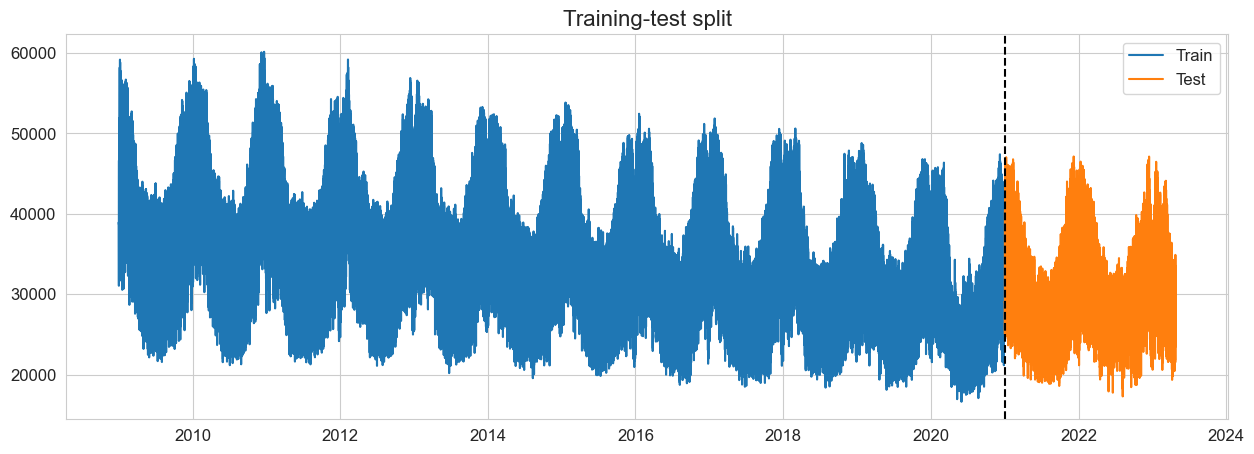

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(train['ds'], train['y'],  label="Train")
plt.plot(test['ds'], test['y'],  label="Test")
plt.axvline(datetime.date(2021,1,1), color="black", ls="--")
ax.set_title("Training-test split")
plt.legend();

<a id='first_model'></a>
## First Prophet model

In [51]:
prophet = Prophet(interval_width=0.95)

In [55]:
%%time
# fit the model
prophet.fit(train)

Wall time: 19min 18s


In [40]:
# compute predictions
prophet_pred = prophet.predict(test)
prophet_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01 00:00:00,28118.036479,21094.501815,31223.794745,28118.036479,28118.036479,-1714.026218,-1714.026218,-1714.026218,-5486.336077,...,1450.697166,1450.697166,1450.697166,2321.612693,2321.612693,2321.612693,0.0,0.0,0.0,26404.010261
1,2021-01-01 00:30:00,28117.967210,20495.327931,30943.293417,28117.967210,28117.967210,-2215.649565,-2215.649565,-2215.649565,-5978.690844,...,1438.651263,1438.651263,1438.651263,2324.390016,2324.390016,2324.390016,0.0,0.0,0.0,25902.317645
2,2021-01-01 01:00:00,28117.897941,20584.560330,30737.076911,28117.897941,28117.897941,-2595.658649,-2595.658649,-2595.658649,-6348.728657,...,1425.886754,1425.886754,1425.886754,2327.183253,2327.183253,2327.183253,0.0,0.0,0.0,25522.239292
3,2021-01-01 01:30:00,28117.828672,20339.074316,30274.768039,28117.828672,28117.828672,-2935.690628,-2935.690628,-2935.690628,-6678.040543,...,1412.357534,1412.357534,1412.357534,2329.992381,2329.992381,2329.992381,0.0,0.0,0.0,25182.138044
4,2021-01-01 02:00:00,28117.759403,19895.698703,29866.752385,28117.759403,28117.759403,-3291.399058,-3291.399058,-3291.399058,-7022.232926,...,1398.016495,1398.016495,1398.016495,2332.817373,2332.817373,2332.817373,0.0,0.0,0.0,24826.360345


In [16]:
# save the model
# joblib.dump(prophet, project_path.joinpath('data/models/prophet.pkl'))

# load the model
# prophet = joblib.load(project_path.joinpath('data/models/prophet.pkl')) 

###### Prediction components

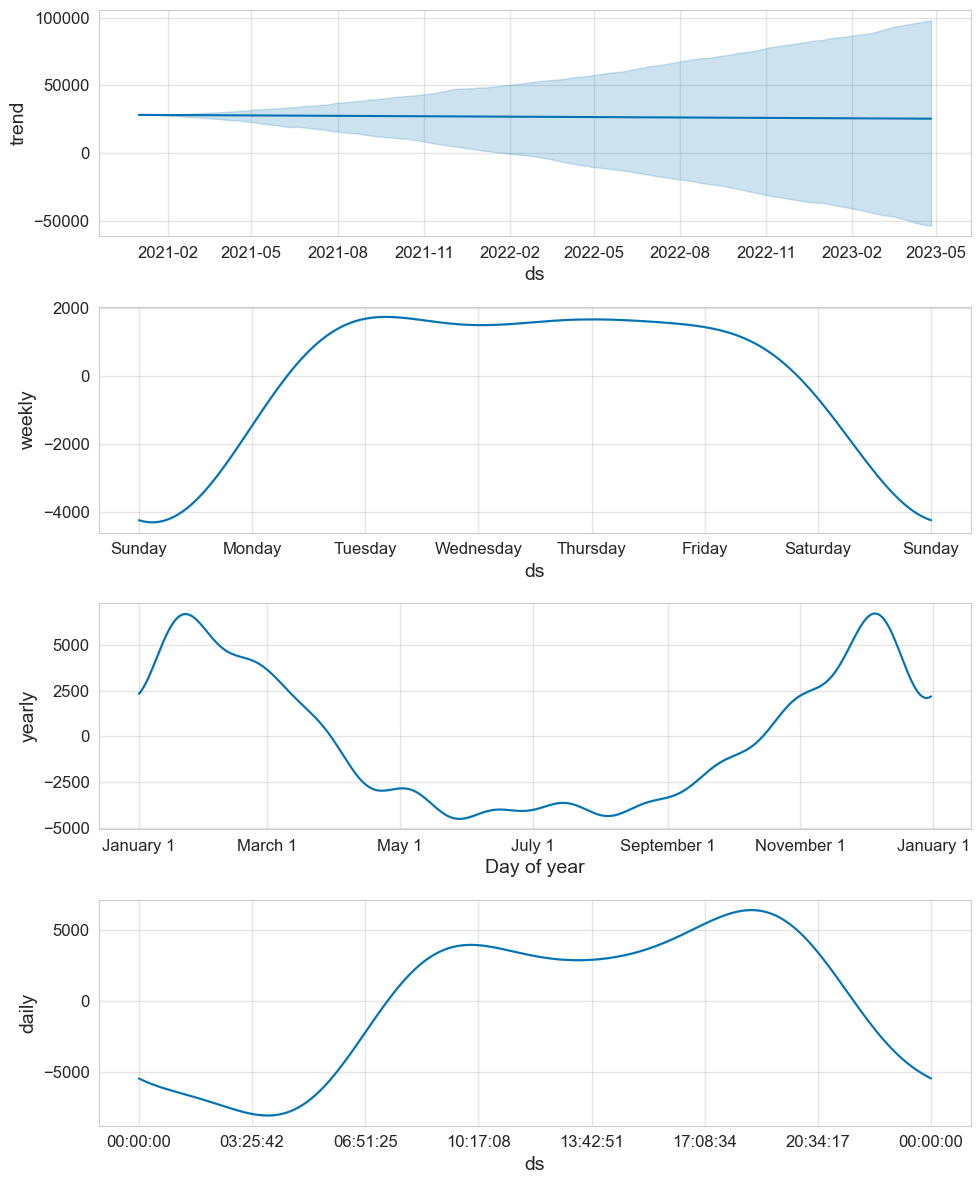

In [11]:
fig = prophet.plot_components(prophet_pred,figsize=(10,12))
plt.savefig("../graphs/prophet_comp.png")

###### Prediction on test set

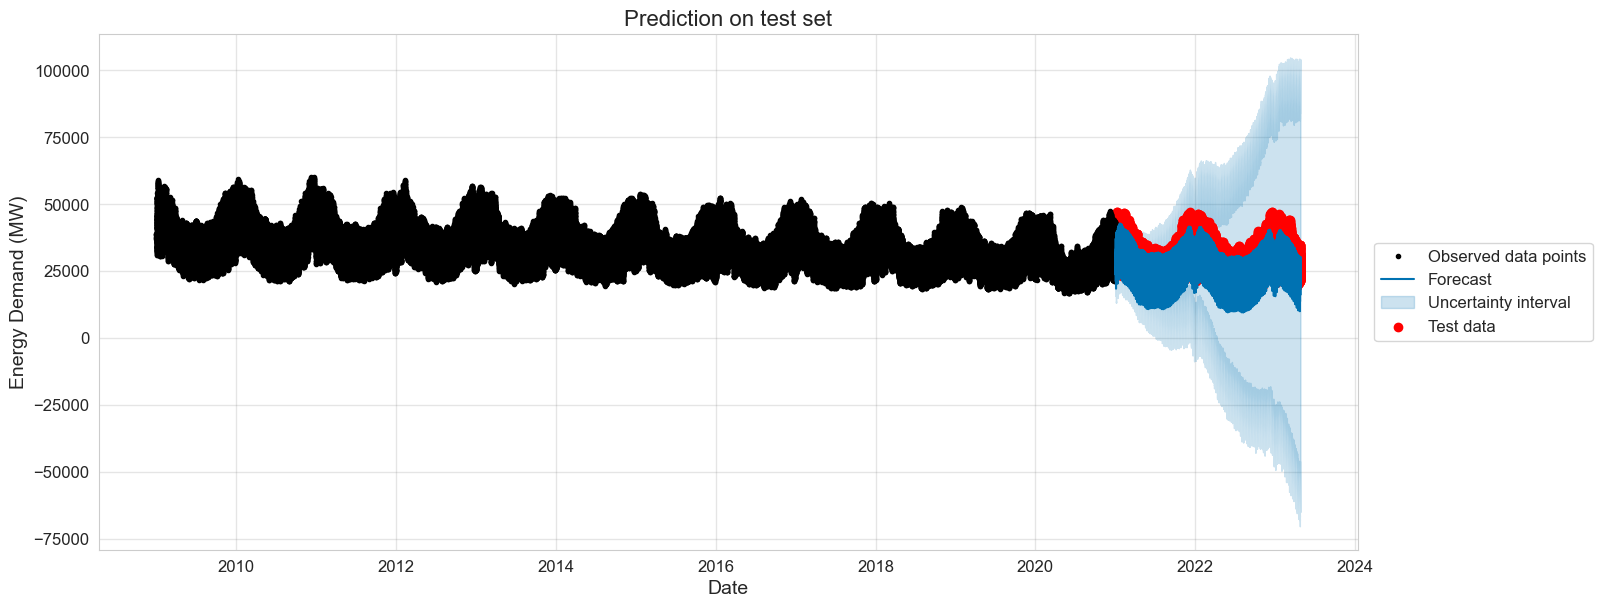

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))

prophet_plot(m=prophet, fcst=prophet_pred, ax=ax, include_legend=True)
ax.scatter(test['ds'], test['y'], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

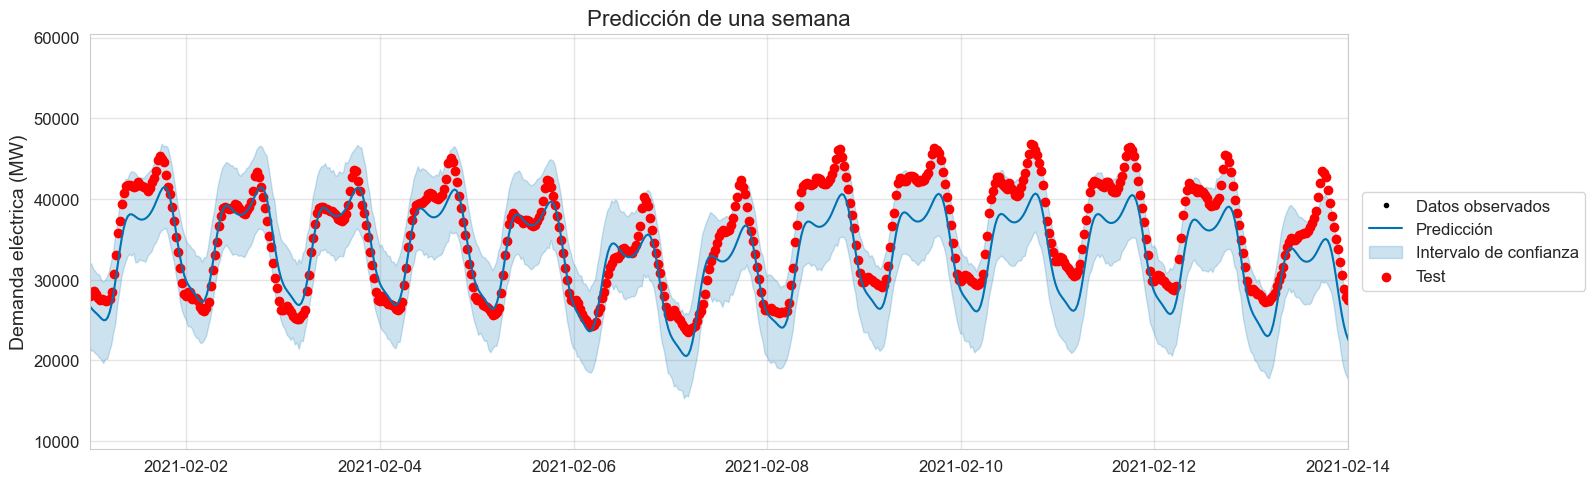

In [42]:
fig, ax = plt.subplots(figsize=(14,5))

prophet_plot(m=prophet, fcst=prophet_pred, ax=ax, include_legend=True)
ax.scatter(test['ds'], test['y'], color='r', label="Test")
ax.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))
ax.set_ylim(9000, 60500)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Predicción de una semana")
ax.set_ylabel("Demanda eléctrica (MW)")
ax.set_xlabel("");
plt.savefig("../graphs/prophet_oneweek_pred.png")

###### MAPE and MSE error

In [14]:
mape_prophet_simple = mean_absolute_percentage_error(test['y'], prophet_pred["yhat"])
mse_prophet_simple = mean_squared_error(test['y'], prophet_pred["yhat"])

print("MAPE: ", mape_prophet_simple)
print("MSE: ",  mse_prophet_simple)

MAPE:  11.872117333474652
MSE:  17655407.34241121


<a id='hday'></a>
## Prophet with holidays

In [26]:
import holidays
bank_holiday_england = holidays.UK(subdiv="England", years=range(2009, 2024), observed=True).items()

In [27]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

In [28]:
holiday_df = pd.DataFrame(data={"ds": holiday_dates_observed, "holiday": holiday_names_observed})
holiday_df.head()

,ds,holiday
0,2009-01-01,New Year's Day
1,2009-04-10,Good Friday
2,2009-04-13,Easter Monday
3,2009-05-04,May Day
4,2009-05-25,Spring Bank Holiday


In [18]:
%%time
# fit the model
prophet_hday = Prophet(holidays=holiday_df, interval_width=0.95)
prophet_hday.fit(train)

Wall time: 26min 54s


In [31]:
#compute predictions
prophet_hday_pred = prophet_hday.predict(test)

In [29]:
# save the model
# joblib.dump(prophet_hday, project_path.joinpath('data/models/prophet_hday.pkl'))

# load the model
prophet_hday = joblib.load(project_path.joinpath('data/models/prophet_hday.pkl'))

###### Graphic of the components (now with holiday's effect)

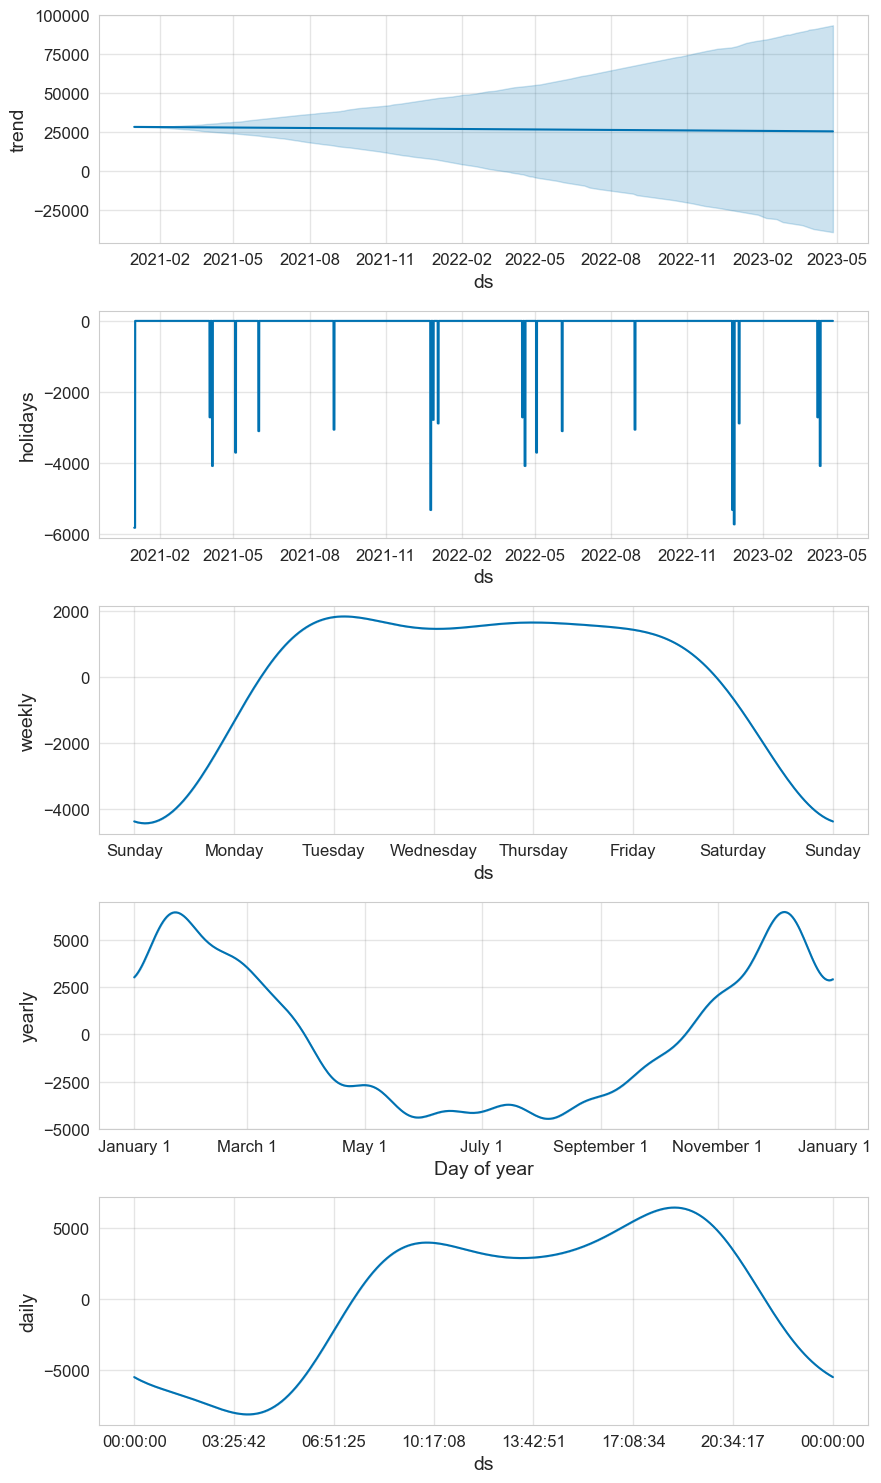

In [21]:
prophet_hday.plot_components(prophet_hday_pred);

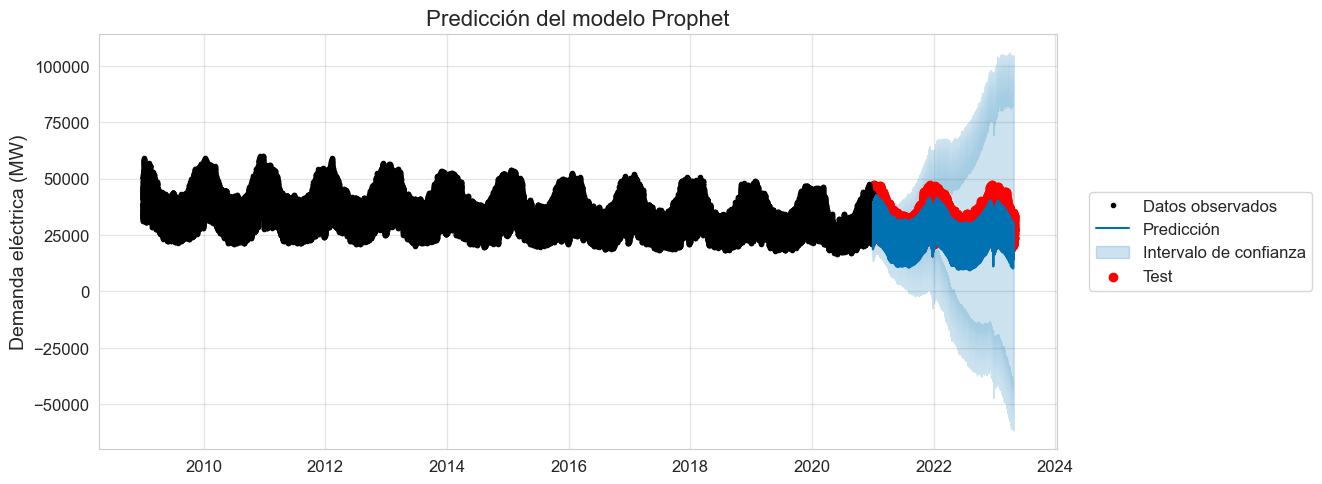

In [38]:
fig, ax = plt.subplots(figsize=(11, 5))

prophet_plot(m=prophet_hday, fcst=prophet_hday_pred, ax=ax, include_legend=True)
ax.scatter(test['ds'], test['y'], color='r', label="Test")
ax.legend(bbox_to_anchor=(1.15, 0.5), loc="center", ncol=1)

ax.set_title("Predicción del modelo Prophet")
ax.set_ylabel("Demanda eléctrica (MW)")
ax.set_xlabel("");
plt.savefig("../graphs/prophet_predition.png")

###### Comparison of the models with and without holidays

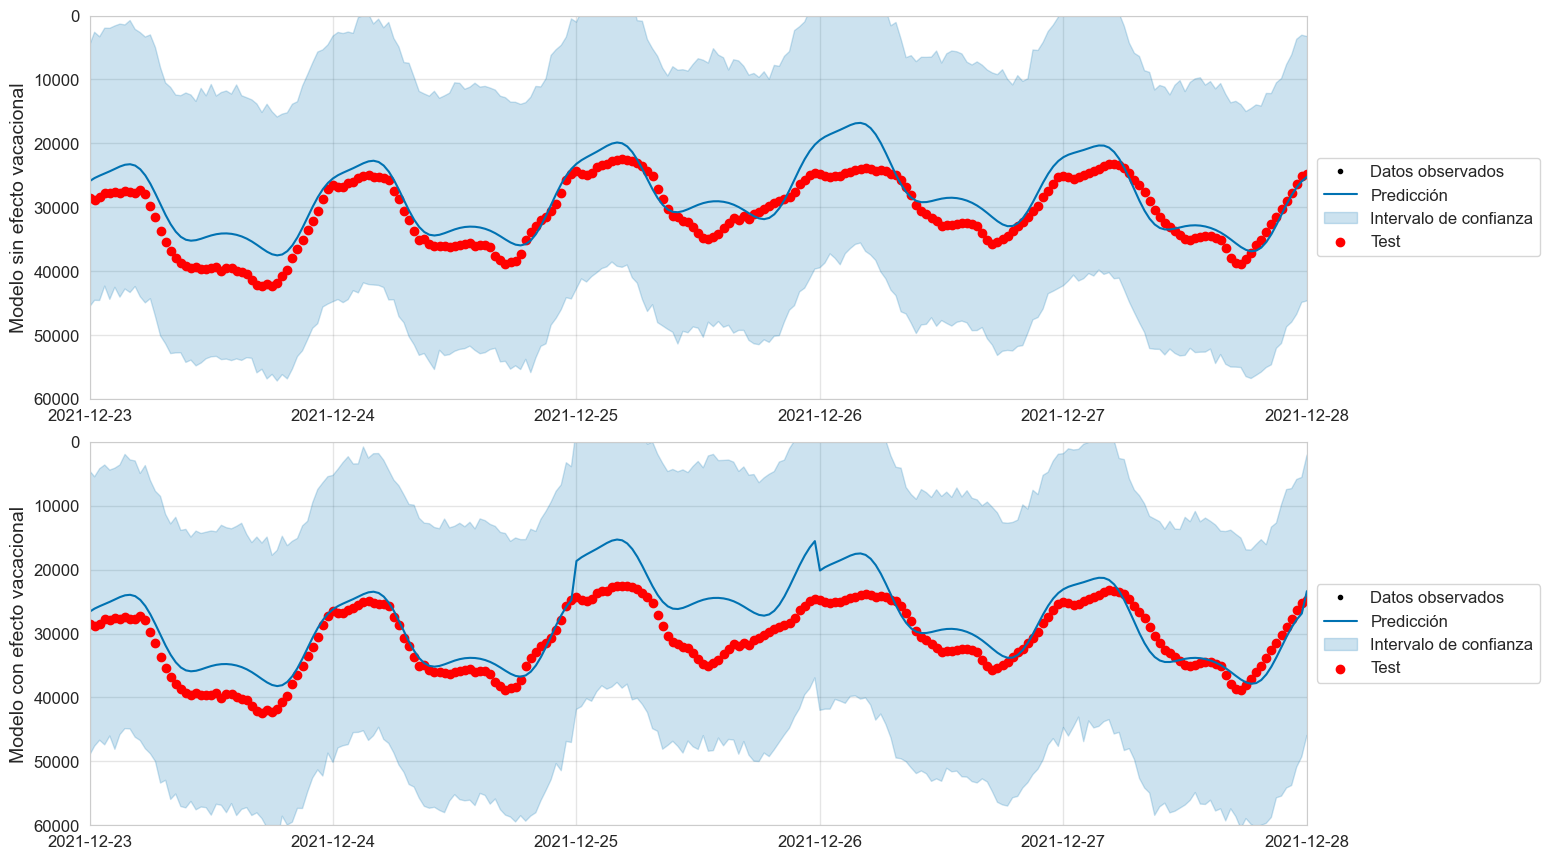

In [49]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,9))

prophet_plot(m=prophet, fcst=prophet_pred, ax=ax1, include_legend=True)
ax1.scatter(test['ds'], test['y'], color='r', label="Test")
ax1.set_xlim(left=datetime.date(2021,12,23), right=datetime.date(2021,12,28))
ax1.set_ylim(bottom=60000, top=0)
ax1.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax1.set_ylabel("Modelo sin efecto vacacional")
ax1.set_xlabel('')




prophet_plot(m=prophet_hday, fcst=prophet_hday_pred, ax=ax2, include_legend=True)
ax2.scatter(test['ds'], test['y'], color='r', label="Test")
ax2.set_xlim(left=datetime.date(2021,12,23), right=datetime.date(2021,12,28))
ax2.set_ylim(bottom=60000, top=0)
ax2.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax2.set_ylabel("Modelo con efecto vacacional")
ax2.set_xlabel('')


# plt.savefig("../graphs/prophet_hdaycomparison.png")

##### MAPE and MSE error

In [24]:
mape_prophet_holiday = mean_absolute_percentage_error(test['y'], prophet_hday_pred["yhat"])
mse_prophet_holiday = mean_squared_error(test['y'], prophet_hday_pred["yhat"])
print('MAPE: ', mape_prophet_holiday)
print('MSE: ',  mse_prophet_holiday)

MAPE:  11.88103750232119
MSE:  17677685.275017653


<a id='crossval'></a>
## Using Cross-Validation for the best parameters

In [50]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [51]:
df = pd.read_parquet('../data/02_intermediate/data.parquet')

threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

# Prepare the training, testing and hold-out data
y_train = train_data['tsd']
y_test = test_data['tsd']
y_hold_out = hold_out_data['tsd']
y_all = df['tsd']

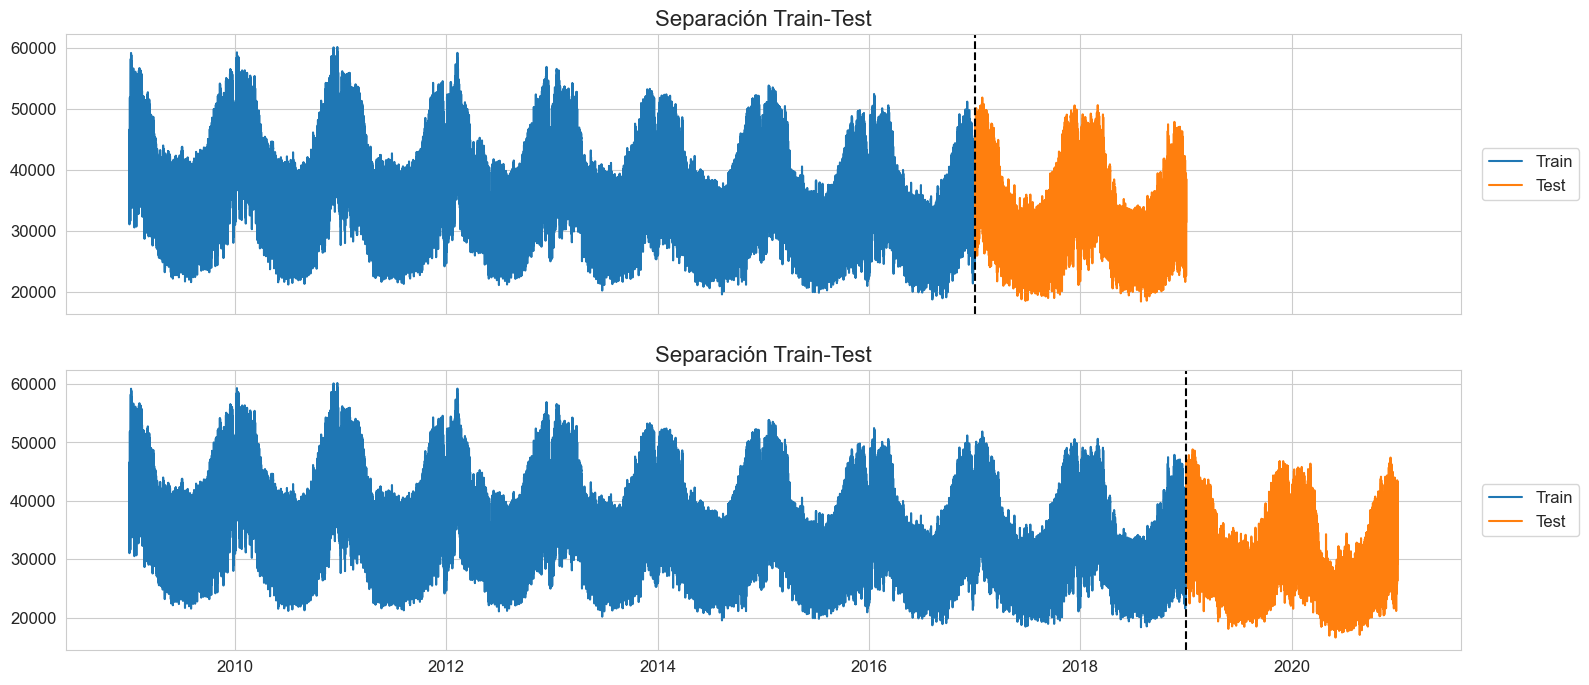

In [58]:
threshold_date = "01-01-2021"
n_years_test = 2
tss_prophet = TimeSeriesSplit(n_splits=2, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True)

fold = 0
for train_index, test_index in tss_prophet.split(df[df.index<threshold_date]):
    train_data = y_all.to_frame().reset_index().iloc[train_index].rename(columns={"settlement_date": "ds", "tsd": "y"})
    test_data  = y_all.to_frame().reset_index().iloc[test_index].rename(columns={"settlement_date": "ds", "tsd": "y"})

    
    axes[fold].plot(train_data["ds"], train_data["y"], label="Train")
    axes[fold].plot(test_data["ds"], test_data["y"], label="Test")
    axes[fold].axvline(test_data["ds"].min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.05, 0.5))

    axes[fold].set_title("Separación Train-Test")
    axes[fold].set_ylabel("")
    axes[fold].set_xlabel("");
    fold += 1
    
plt.savefig("../graphs/prophet_crossval.png")

In [59]:
%%time

# Define the parameter grid for the Prophet model
param_grid = {"changepoint_prior_scale": [0.001, 0.05, .5], "seasonality_prior_scale": [2.5, 10], "holidays_prior_scale": [2.5, 10]}

# Create all possible combinations of the parameter grid
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

rmse_cv_gs = []

for params in all_params:
    rmse_cv = []
    
    for train_index, test_index in tss_prophet.split(df[df.index<threshold_date]):
        train_data = y_all.to_frame().reset_index().iloc[train_index].rename(columns={"settlement_date": "ds", "tsd": "y"})
        test_data  = y_all.to_frame().reset_index().iloc[test_index].rename(columns={"settlement_date": "ds", "tsd": "y"})

        model = Prophet(**params, holidays=holiday_df)
        model.fit(train_data)

        prediction = model.predict(test_data)
        mse_val = mean_squared_error(test_data["y"], prediction["yhat"])
        rmse_cv.append(np.sqrt(mse_val))
    
    rmse_cv_gs.append(np.mean(rmse_cv))
    
grid_search_results = pd.DataFrame(all_params)
grid_search_results['rmse'] = rmse_cv_gs

Wall time: 2h 57min 3s


### Model with the best parameters

In [28]:
best_params = all_params[np.argmin(rmse_cv_gs)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 2.5, 'holidays_prior_scale': 10}


In [8]:
best_params = {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 2.5, 'holidays_prior_scale': 10}

In [33]:
%%time
# Create Prophet using the best parameters from the grid search
prophet_best = Prophet(**best_params, holidays=holiday_df, interval_width=0.95)
prophet_best.fit(train)

prophet_best_pred = prophet_best.predict(test)

Wall time: 5min 25s


In [59]:
# save the model
# joblib.dump(prophet_best, project_path.joinpath('data/models/prophet_best.pkl'))

# load the model
prophet_best = joblib.load(project_path.joinpath('data/models/prophet_best.pkl'))
prophet_best_pred = prophet_best.predict(test)

###### MAPE and MSE error

In [60]:
mape_prophet_best = mean_absolute_percentage_error(test['y'], prophet_best_pred["yhat"])
mse_prophet_best = mean_squared_error(test['y'], prophet_best_pred["yhat"])
print("MAPE: ", mape_prophet_best)
print('MSE:', mse_prophet_best)

MAPE:  11.833851742610877
MSE: 17408856.23143441


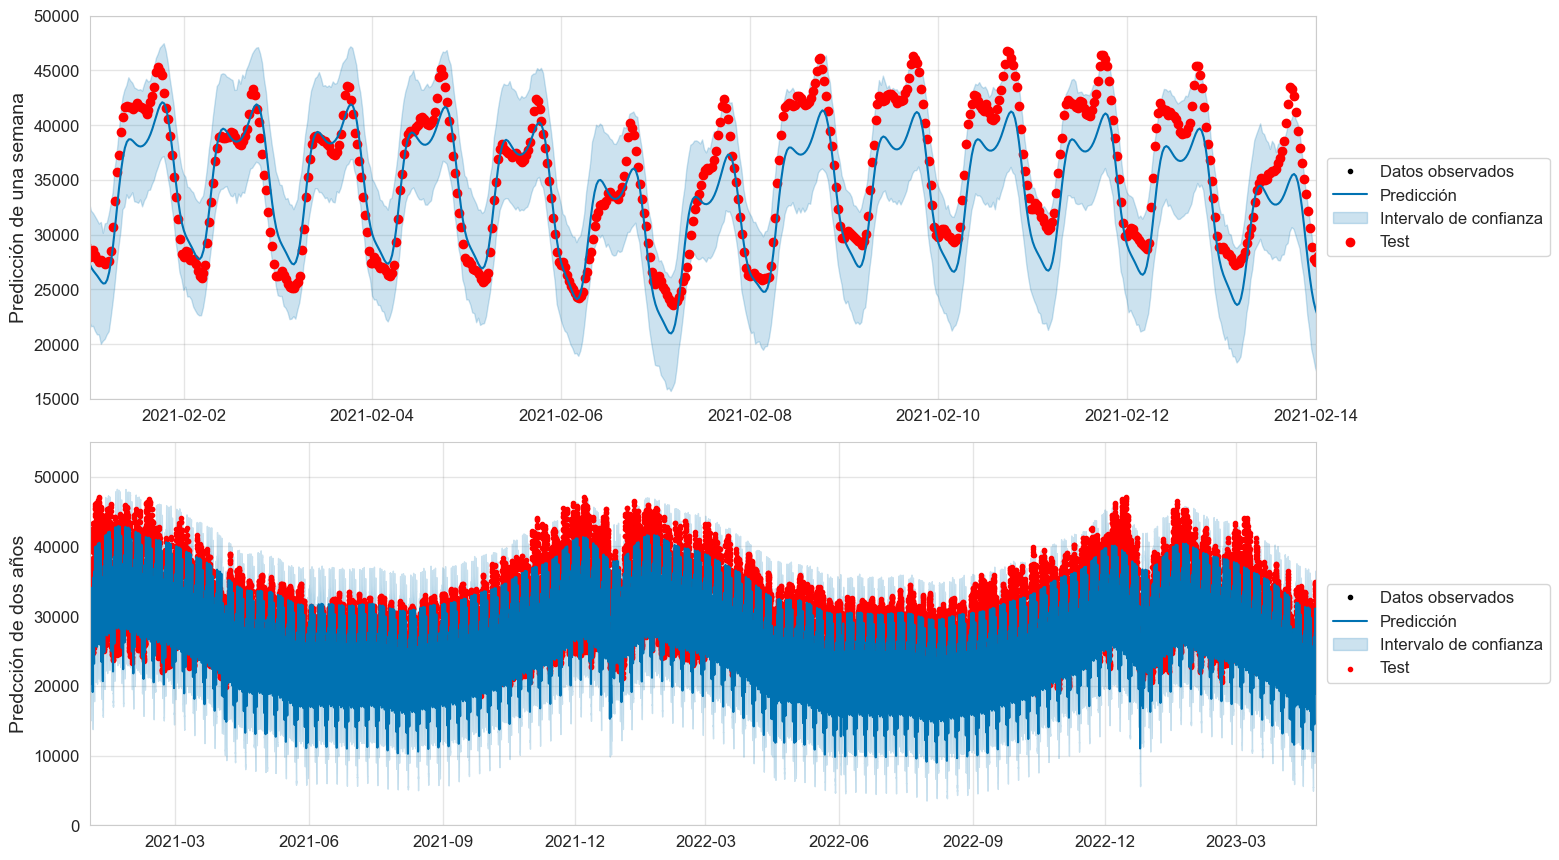

In [61]:
fig, (ax, bx) = plt.subplots(2,1,figsize=(16,9))

prophet_plot(m=prophet_best, fcst=prophet_best_pred, ax=ax, include_legend=True)
ax.scatter(test['ds'], test['y'], color='r', label="Test")
ax.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))
ax.set_ylim(15000, 50000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_ylabel("Predicción de una semana")
ax.set_xlabel("");


prophet_plot(m=prophet_best, fcst=prophet_best_pred, ax=bx, include_legend=True)
bx.scatter(test['ds'], test['y'], marker='.',color='r', label="Test")
bx.set_xbound(lower=datetime.date(2021,1,1), upper=datetime.date(2023,4,25))
bx.set_ylim(0, 55000)
bx.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
bx.set_ylabel("Predcción de dos años")
bx.set_xlabel("");

plt.savefig("../graphs/prophet_pred2.png")

<a id='future'></a>
## Prediction into the future

In [45]:
%%time
# Fit a new model using all the data as training data
prophet_future = Prophet(**best_params, holidays=holiday_df, interval_width=0.95)
prophet_future.fit(all_data)

Wall time: 6min 58s


In [64]:
future_days = prophet_future.make_future_dataframe(periods=250*24, freq="H", include_history=False)
prophet_forecast = prophet_future.predict(future_days)

In [63]:
# save the model
# joblib.dump(prophet_future, project_path.joinpath('data/models/prophet_future.pkl'))

# load the model
# prophet_future = joblib.load(project_path.joinpath('data/models/prophet_future.pkl'))

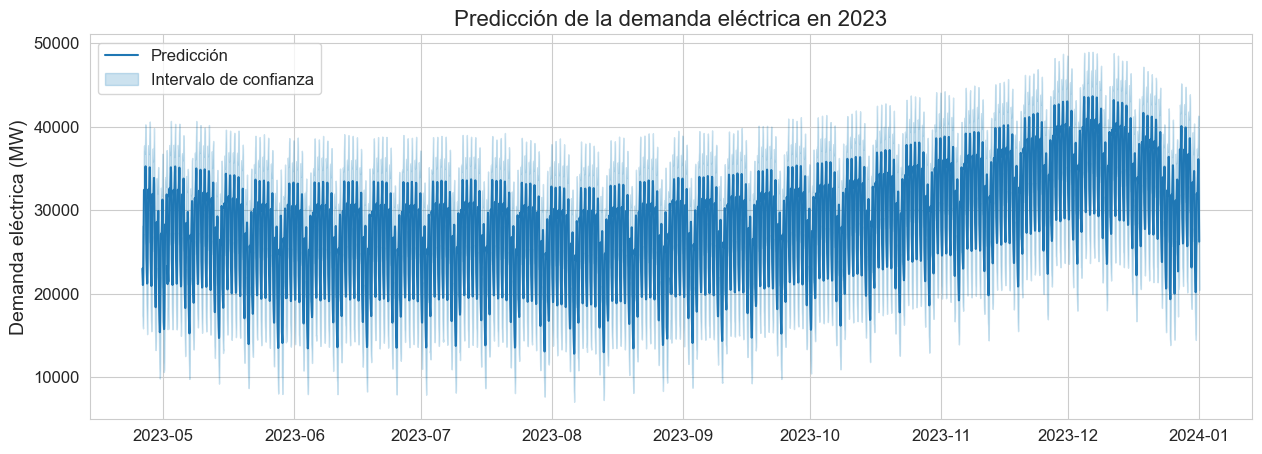

In [66]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(prophet_forecast["ds"], prophet_forecast["yhat"], label='Predicción')

ax.set_xlabel("")
ax.set_ylabel("Demanda eléctrica (MW)")
ax.set_title("Predicción de la demanda eléctrica en 2023")
ax.fill_between(future_days.ds, prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'],
                        color='#0072B2', alpha=0.2, label='Intervalo de confianza')
ax.legend(loc='upper left')
plt.savefig("../graphs/prophet_future_predition.png")

<a id='graphs'></a>
## Other plots

##### Changepoints

In [8]:
def add_changepoints_to_plot(
    ax, m, fcst, threshold=0.01, cp_color='r', cp_linestyle='--', trend=True,
):
    """Add markers for significant changepoints to prophet forecast plot.

    Example:
    fig = m.plot(forecast)
    add_changepoints_to_plot(fig.gca(), m, forecast)

    Parameters
    ----------
    ax: axis on which to overlay changepoint markers.
    m: Prophet model.
    fcst: Forecast output from m.predict.
    threshold: Threshold on trend change magnitude for significance.
    cp_color: Color of changepoint markers.
    cp_linestyle: Linestyle for changepoint markers.
    trend: If True, will also overlay the trend.

    Returns
    -------
    a list of matplotlib artists
    """
    artists = []
    if trend:
        artists.append(ax.plot(fcst['ds'], fcst['trend'], c=cp_color))
    signif_changepoints = m.changepoints[
        np.abs(np.nanmean(m.params['delta'], axis=0)) >= threshold
    ] if len(m.changepoints) > 0 else []
    for cp in signif_changepoints:
        artists.append(ax.axvline(x=cp, c=cp_color, ls=cp_linestyle))
    return artists

In [9]:
newtrain = pd.read_parquet('../data/03_train-test/train_data.parquet')
newtrain = newtrain[:365*48]

In [10]:
%%time
m = Prophet()
m.fit(newtrain)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Wall time: 1min 16s


In [11]:
forecast = m.predict(newtrain)

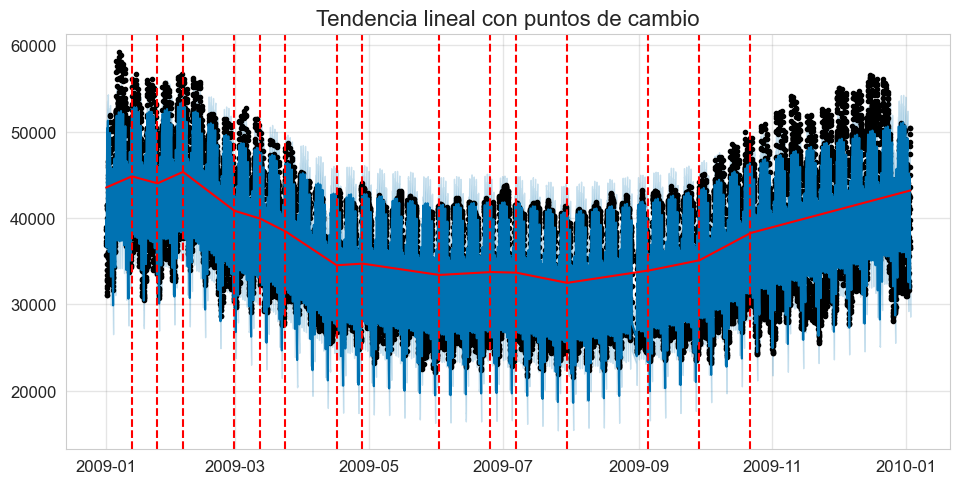

In [69]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast, figsize=(10,5))
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title('Tendencia lineal con puntos de cambio')
plt.ylabel('')
plt.xlabel('')
plt.savefig("../graphs/changepoints.png")

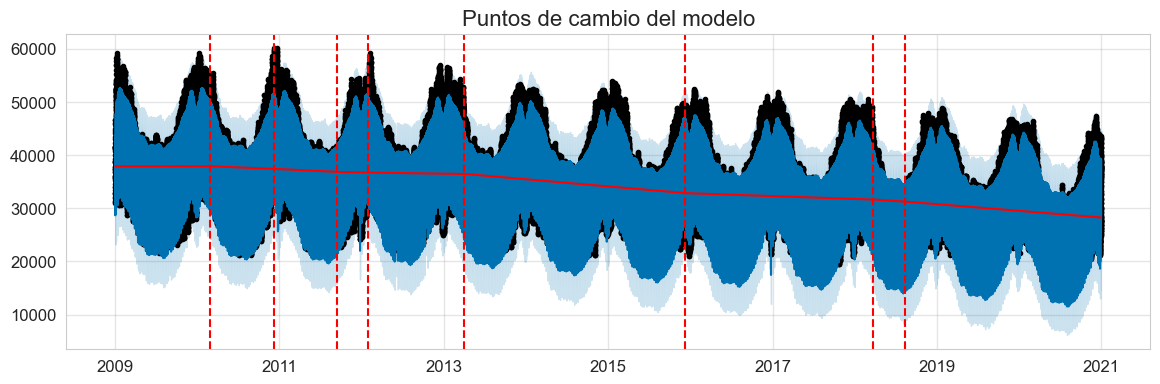

In [74]:
pred = prophet_best.predict(train)
fig = prophet_best.plot(pred, figsize=(12,4))
a = add_changepoints_to_plot(fig.gca(), prophet_best, pred)
plt.title('Puntos de cambio del modelo')
plt.ylabel('')
plt.xlabel('')
plt.savefig("../graphs/changepoints2.png")

##### Component visualitation

In [13]:
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import num2date, AutoDateLocator, AutoDateFormatter

# this functions are from the fbprophet documentation

def seasonality_plot_df(m, ds):
    """Prepare dataframe for plotting seasonal components.

    Parameters
    ----------
    m: Prophet model.
    ds: List of dates for column ds.

    Returns
    -------
    A dataframe with seasonal components on ds.
    """
    df_dict = {'ds': ds, 'cap': 1., 'floor': 0.}
    for name in m.extra_regressors:
        df_dict[name] = 0.
    # Activate all conditional seasonality columns
    for props in m.seasonalities.values():
        if props['condition_name'] is not None:
            df_dict[props['condition_name']] = True
    df = pd.DataFrame(df_dict)
    df = m.setup_dataframe(df)
    return df


def plot_seasonality(m, name, ax=None, uncertainty=True, figsize=(10, 6)):
    """Plot a custom seasonal component.

    Parameters
    ----------
    m: Prophet model.
    name: Seasonality name, like 'daily', 'weekly'.
    ax: Optional matplotlib Axes to plot on. One will be created if
        this is not provided.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    figsize: Optional tuple width, height in inches.

    Returns
    -------
    a list of matplotlib artists
    """
    artists = []
    if not ax:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    # Compute seasonality from Jan 1 through a single period.
    start = pd.to_datetime('2017-01-01 0000')
    period = m.seasonalities[name]['period']
    end = start + pd.Timedelta(days=period)
    plot_points = 200
    days = pd.to_datetime(np.linspace(start.value, end.value, plot_points))
    df_y = seasonality_plot_df(m, days)
    seas = m.predict_seasonal_components(df_y)
    artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
                        c='#0072B2')
    if uncertainty and m.uncertainty_samples:
        artists += [ax.fill_between(
            df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],
            seas[name + '_upper'], color='#0072B2', alpha=0.2)]
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    n_ticks = 8
    xticks = pd.to_datetime(np.linspace(start.value, end.value, n_ticks)
        ).to_pydatetime()
    ax.set_xticks(xticks)
    if name == 'yearly':
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%B} {dt.day}'.format(dt=num2date(x)))
        ax.set_xlabel('Day of year')
    elif name == 'weekly':
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%A}'.format(dt=num2date(x)))
        ax.set_xlabel('Day of Week')
    elif name == 'daily':
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%T}'.format(dt=num2date(x)))
        ax.set_xlabel('Hour of day')
    elif period <= 2:
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%T}'.format(dt=num2date(x)))
        ax.set_xlabel('Hours')
    else:
        fmt = FuncFormatter(
            lambda x, pos=None: '{:.0f}'.format(pos * period / (n_ticks - 1)))
        ax.set_xlabel('Days')
    ax.xaxis.set_major_formatter(fmt)
    ax.set_ylabel(name)
    if m.seasonalities[name]['mode'] == 'multiplicative':
        ax = set_y_as_percent(ax)
    return artists


def plot_forecast_component(
    m, fcst, name, ax=None, uncertainty=True, plot_cap=False, figsize=(10, 6)
):
    """Plot a particular component of the forecast.

    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    name: Name of the component to plot.
    ax: Optional matplotlib Axes to plot on.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    figsize: Optional tuple width, height in inches.

    Returns
    -------
    a list of matplotlib artists
    """
    artists = []
    if not ax:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    fcst_t = fcst['ds'].dt.to_pydatetime()
    artists += ax.plot(fcst_t, fcst[name], ls='-', c='#0072B2')
    if 'cap' in fcst and plot_cap:
        artists += ax.plot(fcst_t, fcst['cap'], ls='--', c='k')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k')
    if uncertainty and m.uncertainty_samples:
        artists += [ax.fill_between(
            fcst_t, fcst[name + '_lower'], fcst[name + '_upper'],
            color='#0072B2', alpha=0.2)]
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel('ds')
    ax.set_ylabel(name)
    if name in m.component_modes['multiplicative']:
        ax = set_y_as_percent(ax)
    return artists

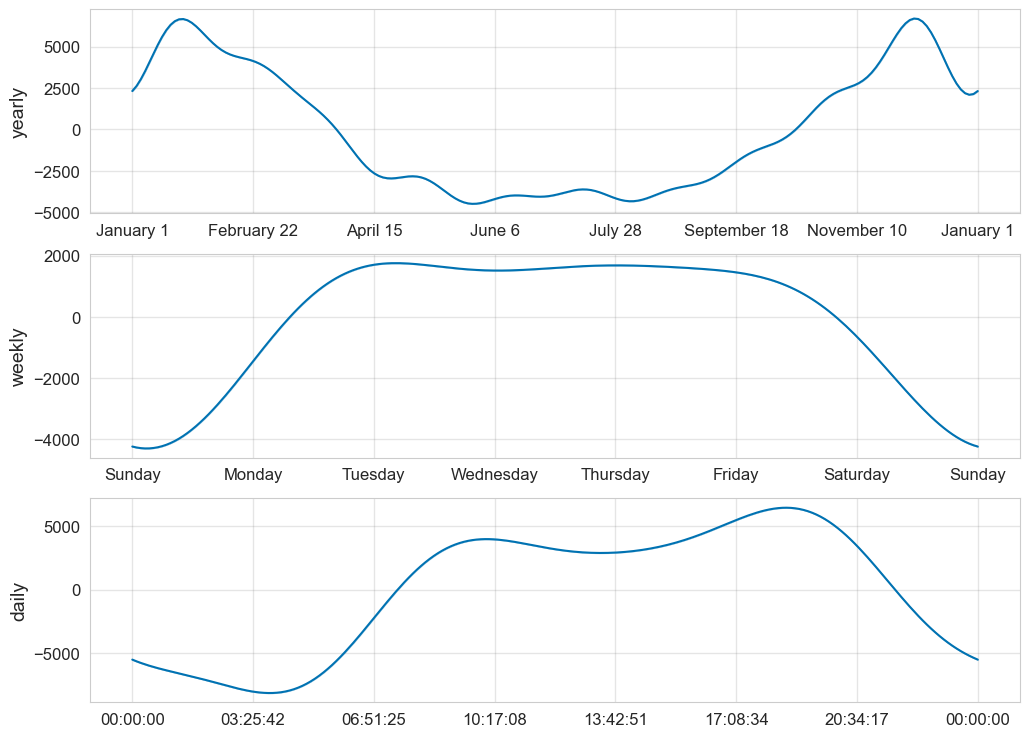

In [24]:
fig, ax = plt.subplots(3, figsize=(12,9))
plot_seasonality(m=prophet, name='yearly', ax=ax[0])
ax[0].set_xlabel('')
plot_seasonality(m=prophet, name='weekly', ax=ax[1])
ax[1].set_xlabel('')
plot_seasonality(m=prophet, name='daily', ax=ax[2])
ax[2].set_xlabel('')
plt.savefig("../graphs/prophet_comp.png")

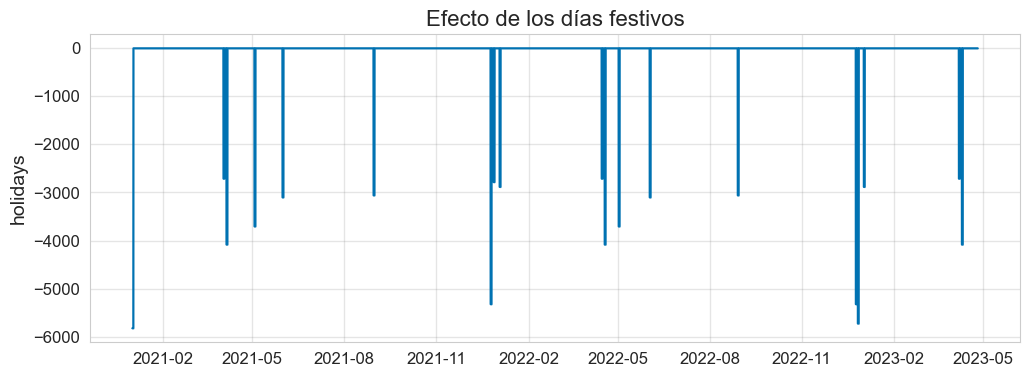

In [32]:
plot_forecast_component(m=prophet_hday, fcst=prophet_hday_pred, name='holidays', figsize=(12,4))
plt.title('Efecto de los días festivos')
plt.xlabel('')
plt.savefig("../graphs/prophet_hday.png")